In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures, SplineTransformer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

from sklearn.feature_selection import SelectKBest, RFECV, SelectFromModel
from sklearn.feature_selection import f_classif, f_regression
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor

In [11]:
train_df = pd.read_csv('data/pass_satisfaction_train.csv')
test_df = pd.read_csv('data/pass_satisfaction_test.csv')

target = 'satisfaction'  
train_df = train_df.rename(columns={target: 'target'})

In [12]:
train_df

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,target
0,110028,0,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
1,24026,0,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
2,111157,0,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
3,82113,1,Loyal Customer,47,Personal Travel,Eco,1276,2,4,2,...,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
4,79485,0,Loyal Customer,41,Business travel,Business,853,1,2,2,...,1,1,2,1,4,1,2,0,0.0,neutral or dissatisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83118,94171,0,disloyal Customer,23,Business travel,Eco,192,2,1,2,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
83119,73097,1,Loyal Customer,49,Business travel,Business,2347,4,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
83120,68825,1,disloyal Customer,30,Business travel,Business,1995,1,1,1,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
83121,54173,0,disloyal Customer,22,Business travel,Eco,1000,1,1,1,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


/tmp/ipykernel_214685/3411871248.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), cmap="PiYG", annot=True, fmt='.3g')


<AxesSubplot: >

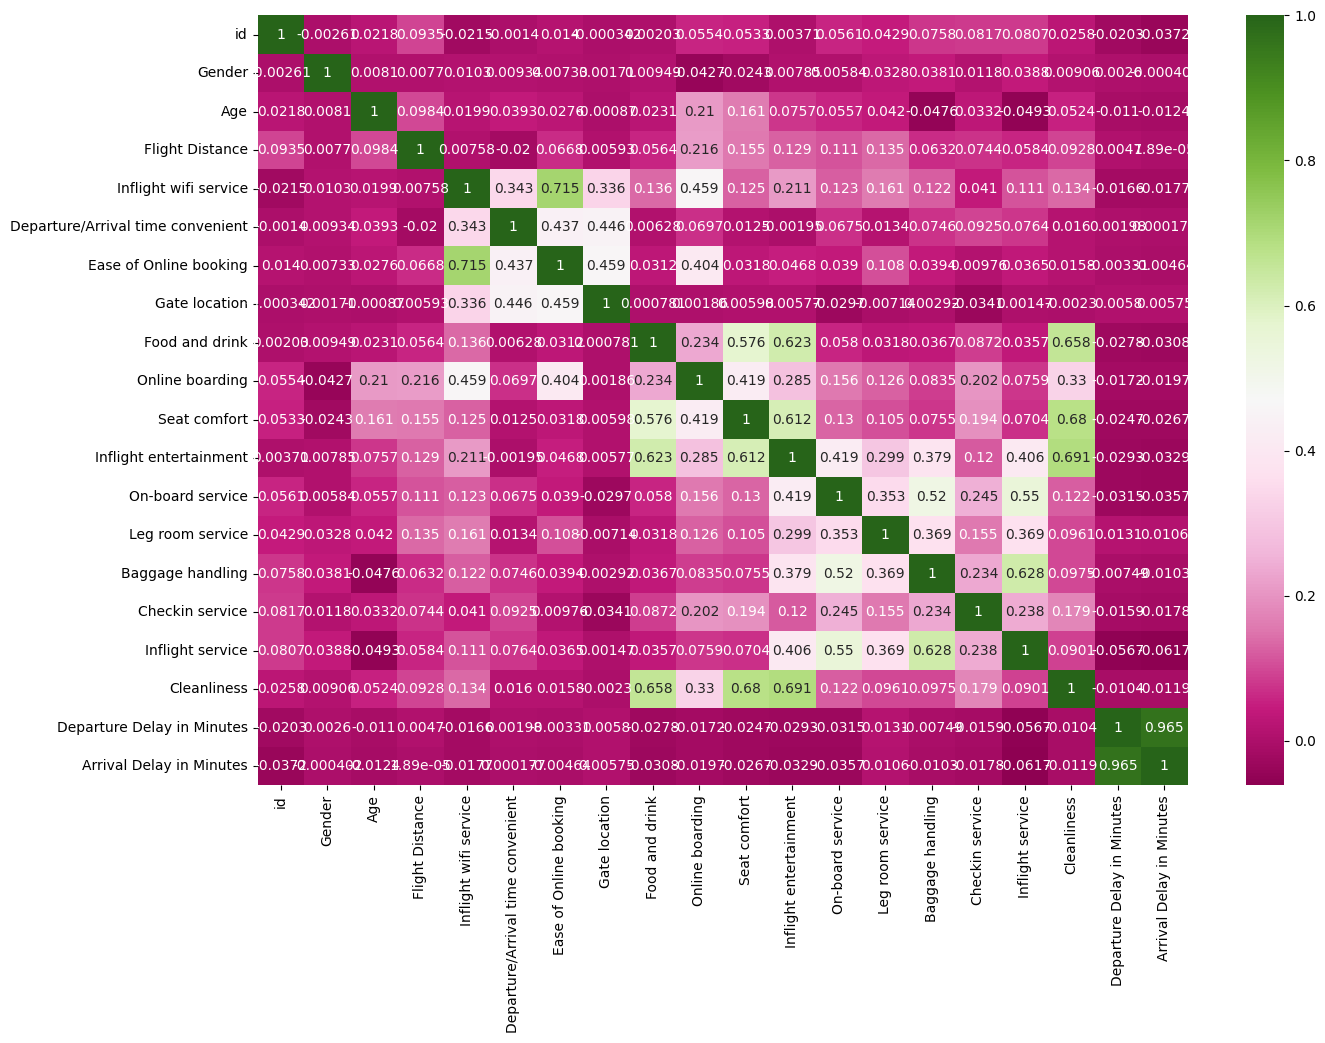

In [13]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_df.corr(), cmap="PiYG", annot=True, fmt='.3g')

In [14]:
train_df.isna().sum(0)

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             239
target                                 0
dtype: int64

In [15]:
temp_df = train_df.query("`Departure Delay in Minutes` != 0 and `Arrival Delay in Minutes` !=0").dropna()

In [16]:
(temp_df['Arrival Delay in Minutes'] / temp_df['Departure Delay in Minutes']).median()

0.9414634146341463

In [17]:
train_df['Arrival Delay in Minutes'] = train_df['Arrival Delay in Minutes'].fillna(train_df['Departure Delay in Minutes'] * 0.94)
test_df['Arrival Delay in Minutes'] = test_df['Arrival Delay in Minutes'].fillna(test_df['Departure Delay in Minutes'] * 0.94)

In [18]:
train_df.nunique() 

id                                   83123
Gender                                   2
Customer Type                            2
Age                                     75
Type of Travel                           2
Class                                    3
Flight Distance                       3768
Inflight wifi service                    6
Departure/Arrival time convenient        6
Ease of Online booking                   6
Gate location                            6
Food and drink                           6
Online boarding                          6
Seat comfort                             6
Inflight entertainment                   6
On-board service                         6
Leg room service                         6
Baggage handling                         5
Checkin service                          6
Inflight service                         6
Cleanliness                              6
Departure Delay in Minutes             426
Arrival Delay in Minutes               521
target     

In [19]:
pd.concat([train_df,test_df]).nunique() - train_df.nunique()

id                                   20781
Gender                                   0
Customer Type                            0
Age                                      0
Type of Travel                           0
Class                                    0
Flight Distance                         34
Inflight wifi service                    0
Departure/Arrival time convenient        0
Ease of Online booking                   0
Gate location                            0
Food and drink                           0
Online boarding                          0
Seat comfort                             0
Inflight entertainment                   0
On-board service                         0
Leg room service                         0
Baggage handling                         0
Checkin service                          0
Inflight service                         0
Cleanliness                              0
Departure Delay in Minutes              20
Arrival Delay in Minutes                38
target     

In [21]:
class ColumnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

In [26]:
cat_cols = [x for x in train_df.nunique()[train_df.nunique() < 20].index.to_list() if x != 'target']
num_cols = [column for column in train_df.columns if column not in cat_cols + ['target']]

cat_steps = [
    ('onehot', OneHotEncoder(handle_unknown='ignore',)),
]
num_steps = [
    ('dropper', ColumnDropperTransformer(['id'])),
    ('scaler1', StandardScaler()),
    # ('pwr', PowerTransformer()),
    # ('imputer', KNNImputer(n_neighbors=6)),
    ('poly', PolynomialFeatures(3, include_bias=False)),
    ('scaler', StandardScaler()),
    # ('f_select', SelectKBest(f_classif, k=40)),
    
]

cat_transformer = Pipeline(cat_steps)
num_transformer = Pipeline(num_steps)
preprocessor = ColumnTransformer(
    [
        ('num',  num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)



model = LogisticRegression(max_iter= 1000, random_state=42)

pipe = Pipeline([
    ('prep', preprocessor),
    ('model', model)
])

In [23]:
enc = LabelEncoder()

X = train_df.drop('target', axis=1)
y = enc.fit_transform(train_df['target'])

In [27]:
cv_oupt = cross_validate(pipe, X, y, cv=5, scoring='f1', return_estimator=True)
scores = cv_oupt['test_score']
models = cv_oupt['estimator']

In [25]:
# Без
scores.mean(), scores.std() 

(0.92356820193781, 0.0012249731662285772)

In [28]:
# С
scores.mean(), scores.std() 

(0.9236328803353793, 0.0010408010966299378)

In [ ]:
1/0

In [ ]:
preds = []
for model in models:
    pred = model.predict_proba(test_df)
    preds.append(pred)

In [ ]:
preds = np.array(preds)

In [ ]:
subm_preds = enc.inverse_transform(preds.mean(axis=0).argmax(axis=1))

In [ ]:
subm_df = pd.DataFrame({'id': test_df.id, 'satisfaction': subm_preds})

In [ ]:
subm_df

,id,satisfaction
0,40853,neutral or dissatisfied
1,15070,satisfied
2,104309,neutral or dissatisfied
3,36427,satisfied
4,7630,satisfied
...,...,...
20776,16548,neutral or dissatisfied
20777,11384,satisfied
20778,58327,neutral or dissatisfied
20779,113956,satisfied


In [ ]:
subm_df.to_csv('subm.csv', index=False)